In [21]:
import pandas as pd
import numpy as np
import datetime as dt

import scipy.stats as stats
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm import tqdm

In [14]:
data = pd.read_csv('hw5.csv', sep=';', index_col=0)
data.value = data.value.apply(lambda x: float(x.replace(',','.')))
data.head()

,value,experimentVariant
1,9.773113,Treatment
2,9.311246,Treatment
3,11.172828,Treatment
4,11.624510,Treatment
5,10.462331,Treatment


In [16]:
data.groupby('experimentVariant')[['value']].agg(['count','mean','median','std','sum'])

value                                             
                  count       mean     median       std          sum
experimentVariant                                                   
Control             500  10.026867  10.018465  0.979377  5013.433267
Treatment            50  10.367236  10.420193  1.030919   518.361819

## Сравните средние между тестом и контролем:
- Примените бутстрап и u-тест. Опишите предположения , которые требуется соблюдать для каждого из критериев и их гипотезы (действительно ли бутстрап и u-тест сравнивают средние)
- Сравните p-value

### Бутстрап

In [42]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_0: list, # числовые значения первой выборки
    data_1: list, # числовые значения второй выборки
    boot_it: int = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    conf_level: float = 0.95, # уровень значимости,
    ba: bool = False
):

    boot_data = []
    for _ in tqdm(range(boot_it)): # извлекаем подвыборки
        boot_0 = data_0.sample(len(data_0), replace = True).values
        boot_1 = data_1.sample(len(data_1), replace = True).values
        boot_data.append(statistic(boot_0) - statistic(boot_1)) # mean() - применяем статистику
        
    # поправляем смещение
    if ba:
        orig_theta = statistic(data_0)-statistic(data_1) # разница в исходных данных
        boot_theta = np.mean(boot_data) # среднее по бутстрапированной разнице статистик
        delta_val = abs(orig_theta - boot_theta) # дельта для сдвига
        boot_data = [i + delta_val for i in boot_data] # сдвигаем бут разницу статистик, обратите внимание, что тут не вычитание
        print(f"""
            До бутстрапа: {orig_theta},
            После бутстрапа: {boot_theta},
            После коррекции: {np.mean(boot_data)}"""
        )

    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd.DataFrame(boot_data).quantile([left_quant, right_quant])

    # p-value
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd.DataFrame(boot_data)[0], bins = 50, color='b')
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--', color='r')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data statistics": statistic(boot_data), 
            "ci": ci, 
            "p_value": p_value}

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3656.23it/s]



            До бутстрапа: -0.3403698432347646,
            После бутстрапа: -0.3402011533451602,
            После коррекции: -0.3400324634555558


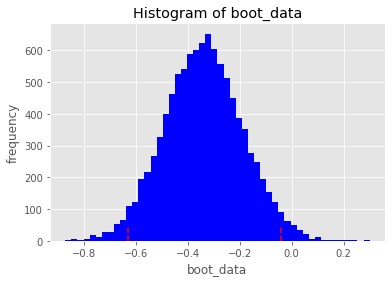

{'boot_data statistics': -0.3400324634555558,
 'ci':               0
 0.025 -0.630914
 0.975 -0.042812,
 'p_value': 0.02390467518144841}

In [43]:
get_bootstrap(
    data_0=data[data.experimentVariant=='Control'].value,
    data_1=data[data.experimentVariant=='Treatment'].value,
    boot_it=10000,
    ba=True
)

### U-тест

In [32]:
control = data[data.experimentVariant=='Control'].value
treatment = data[data.experimentVariant=='Treatment'].value

mannwhitneyu(treatment, control)

MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)